# Fine-tuning Process

In [ ]:
!pip install accelerate -U


In [ ]:
!pip install transformers[torch]

In [ ]:
import re

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForMaskedLM, AdamW, get_linear_schedule_with_warmup, BertModel
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    #device = torch.device("cuda")
    device = torch.cuda.set_device(0)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Load the dataset
dataset_path = 'FineTuningDataset.csv'
df = pd.read_csv(dataset_path)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['input_text'] = df['masked sentence']
df['label_text'] = df.apply(lambda x: x['masked sentence'].replace("[MASK]", x['expected']), axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class MaskedSentenceDataset(Dataset):

  def __init__(self, df: pd.DataFrame, tokenizer):

    self.encodings = self.create_encoding(df, tokenizer)

  def create_encoding(self, df: pd.DataFrame, tokenizer):

    inputs = tokenizer(df['input_text'].tolist(), return_tensors='pt',
                max_length=512, truncation=True, padding='max_length')

    labels = tokenizer(df['label_text'].tolist(), return_tensors='pt',
                max_length=512, truncation=True, padding='max_length')

    inputs['labels'] = labels.input_ids.detach().clone()

    return inputs

  def __len__(self):
    return len(self.encodings.input_ids)

  def __getitem__(self, idx):

    return {'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
         'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
         'labels': torch.tensor(self.encodings['labels'][idx]),
         'token_type_ids': torch.tensor(self.encodings['token_type_ids'][idx])}

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_eval = train_test_split(df, test_size=0.2)

train_dataset = MaskedSentenceDataset(df=df_train, tokenizer=tokenizer)
eval_dataset = MaskedSentenceDataset(df=df_eval, tokenizer=tokenizer)

model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Calculate the number of training steps per epoch
num_training_steps_per_epoch = len(train_dataset) // 8

# Set the total number of training steps based on the number of epochs
num_train_epochs = 4  # original BERT paper recommends 2-4 epoch for fine-tuning
num_training_steps = num_training_steps_per_epoch * num_train_epochs

# Calculate the number of warm-up steps
num_warmup_steps = int(0.1 * num_training_steps)  # Adjust the percentage as needed

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
training_args = TrainingArguments(output_dir='bert_fine_tuned',
    evaluation_strategy="steps",  # evaluate each `logging_steps` steps
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=8,
    eval_steps=100,
    logging_steps=100,  # evaluate, log, and save model checkpoints every 100 steps
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True, # EarlyStoppingCallback is used to avoid overfitting
    warmup_steps=num_warmup_steps,
    disable_tqdm=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

# Start training
trainer.train()

### Results exported in csv files

In [ ]:
from transformers import pipeline

trained_model = BertForMaskedLM.from_pretrained('bert_fine_tuned/checkpoint-500', local_files_only=True)

#model = BertForMaskedLM.from_pretrained('bert-base-uncased')

unmasker = pipeline('fill-mask', model=trained_model, tokenizer=tokenizer)


In [ ]:
humanQue_dataset_path = 'HumanDesignQue.csv'
humanQue_df = pd.read_csv(humanQue_dataset_path)

results = []
# Iterate through the DataFrame
for idx, row in humanQue_df.iterrows():
    # Replace '_' with '[MASK]' in the 'metaphors' column
    masked_metaphor = row['metaphors'].replace('_', '[MASK]')

    # Process the masked metaphor with unmasker
    unmasker_result = unmasker(masked_metaphor)

    # Process each result from unmasker
    for item in unmasker_result:
        result_dict = {
            'idx': idx,  # index of the row in the DataFrame
            'score': item['score'],
            'token_str': item['token_str'],
            'sequence': item['sequence']
        }
        results.append(result_dict)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('HumanQue_unmasker_results.csv', index=False)

In [ ]:
Corpus_dataset_path = 'GeneralCorpus.csv'
Corpus_df = pd.read_csv(Corpus_dataset_path)

results = []
# Iterate through the DataFrame
for idx, row in Corpus_df.iterrows():
    # Replace '_' with '[MASK]' in the 'metaphor' column
    masked_metaphor = row['metaphor'].replace('_', '[MASK]')

    # Process the masked metaphor with unmasker
    unmasker_result = unmasker(masked_metaphor)

    # Process each result from unmasker
    for item in unmasker_result:
        result_dict = {
            'idx': idx,  # index of the row in the DataFrame
            'score': item['score'],
            'token_str': item['token_str'],
            'sequence': item['sequence']
        }
        results.append(result_dict)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('Corpus_unmasker_results.csv', index=False)

In [ ]:
nonMetaphor_dataset_path = 'non-metaphor_COCA.csv'
nonMetaphor_df = pd.read_csv(nonMetaphor_dataset_path)

results = []
# Iterate through the DataFrame
for idx, row in nonMetaphor_df.iterrows():
    # Replace '_' with '[MASK]' in the 'metaphors' column
    masked_nonMetaphor = row['Non-Metaphor'].replace('_', '[MASK]')

    # Process the masked metaphor with unmasker
    unmasker_result = unmasker(masked_nonMetaphor)

    # Process each result from unmasker
    for item in unmasker_result:
        result_dict = {
            'idx': idx,  # index of the row in the DataFrame
            'score': item['score'],
            'token_str': item['token_str'],
            'sequence': item['sequence']
        }
        results.append(result_dict)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('nonMetaphor_unmasker_results.csv', index=False)

### Transform the csv files by aggregating idx

In [ ]:
# Load the CSV file
file_path = 'HumanQue_unmasker_results.csv'
data = pd.read_csv(file_path)

# Grouping the data by 'idx' and aggregating 'score' and 'token_str' into lists
grouped_data = data.groupby('idx').agg({'score': list, 'token_str': list}).reset_index()

# File path for the new CSV file
output_file_path = 'Transformed_HumanQue_unmasker_results.csv'

# Saving the transformed data to a new CSV file
grouped_data.to_csv(output_file_path, index=False)

In [ ]:
# Load the CSV file
file_path = 'Corpus_unmasker_results.csv'
data = pd.read_csv(file_path)

# Grouping the data by 'idx' and aggregating 'score' and 'token_str' into lists
grouped_data = data.groupby('idx').agg({'score': list, 'token_str': list}).reset_index()

# File path for the new CSV file
output_file_path = 'Transformed_Corpus_unmasker_results.csv'

# Saving the transformed data to a new CSV file
grouped_data.to_csv(output_file_path, index=False)

In [ ]:
# Load the CSV file
file_path = 'nonMetaphor_unmasker_results.csv'
data = pd.read_csv(file_path)

# Grouping the data by 'idx' and aggregating 'score' and 'token_str' into lists
grouped_data = data.groupby('idx').agg({'score': list, 'token_str': list}).reset_index()

# File path for the new CSV file
output_file_path = 'Transformed_nonMetaphor_unmasker_results.csv'

# Saving the transformed data to a new CSV file
grouped_data.to_csv(output_file_path, index=False)

# Evaluation: Attention Mechanism Visualization (fine-tuning)

### 1. Human-Designed Questions Metaphor

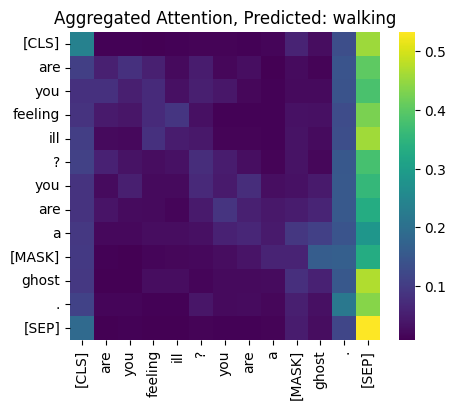

In [ ]:
import torch
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the tokenizer and fine-tuned model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert_fine_tuned/checkpoint-500', output_attentions=True)

# Prepare the input
text = "Are you feeling ill? You are a [MASK] ghost."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()


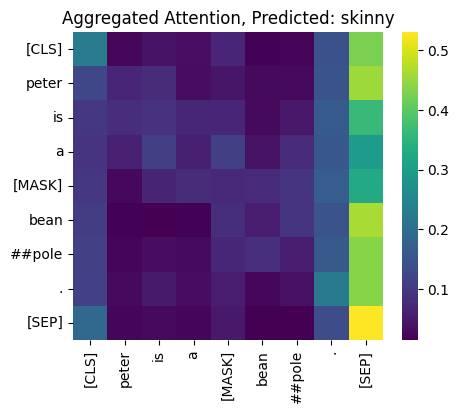

In [ ]:
# Prepare the input
text = "Peter is a [MASK] beanpole."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

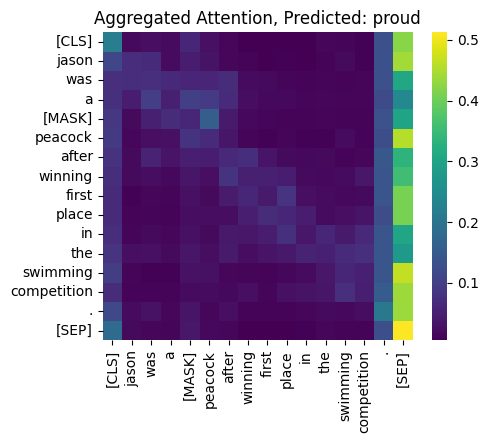

In [ ]:
# Prepare the input
text = "Jason was a [MASK] peacock after winning first place in the swimming competition."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

### 2. General Corpus Metaphor

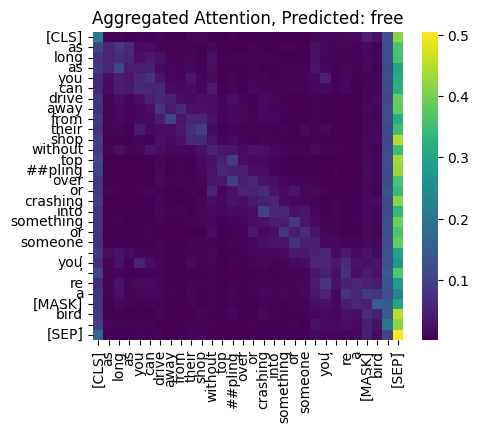

In [ ]:
# Prepare the input
text = "As long as you can drive away from their shop without toppling over or crashing into something or someone, you’re a [MASK] bird."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

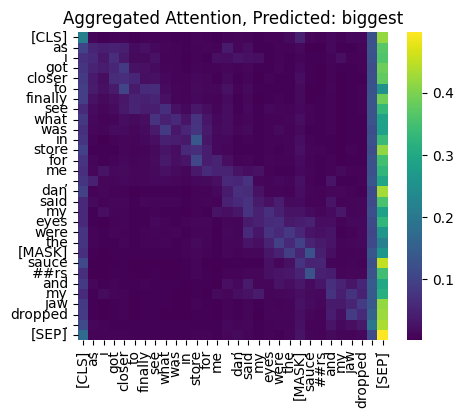

In [ ]:
# Prepare the input
text = "As I got closer to finally see what was in store for me, Dan said my eyes were the [MASK] saucers and my jaw dropped."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

### 3. Non-metaphor

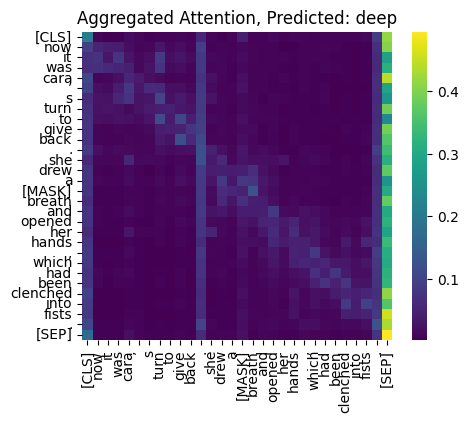

In [ ]:
# Prepare the input
text = "Now it was Cara’s turn to give back. She drew a [MASK] breath and opened her hands, which had been clenched into fists."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

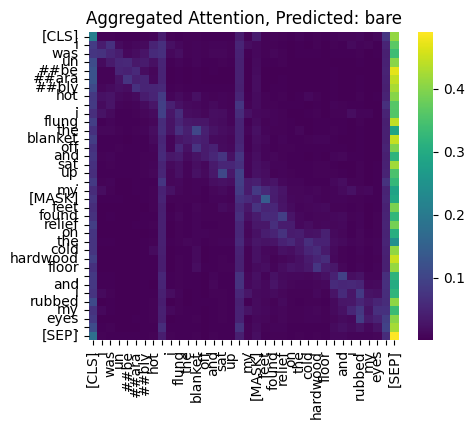

In [ ]:
# Prepare the input
text = "I was unbearably hot. I flung the blanket off and sat up. My [MASK] feet found relief on the cold hardwood floor, and I rubbed my eyes."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()

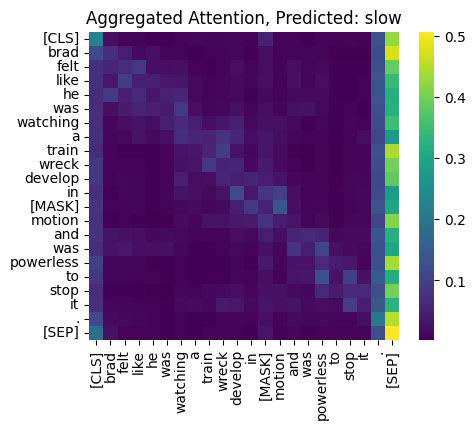

In [ ]:
# Prepare the input
text = "Brad felt like he was watching a train wreck develop in [MASK] motion and was powerless to stop it."
input_ids = tokenizer.encode(text, return_tensors='pt')
mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]

# Get predictions and attention weights
with torch.no_grad():
    outputs = model(input_ids)
    attention = outputs['attentions']
    prediction_scores = outputs['logits']
    predicted_id = torch.argmax(prediction_scores[0, mask_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_id])[0]

# Aggregate the attention weights across all layers and heads
all_layers_attention = torch.stack(attention).mean(dim=0)  # Average over layers
all_heads_attention = all_layers_attention.mean(dim=1)  # Average over heads
avg_attention = all_heads_attention[0].detach().numpy()  # For the first (and only) input in the batch

# Plot the aggregated attention weights as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(avg_attention, annot=False, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
plt.title(f'Aggregated Attention, Predicted: {predicted_token}')
plt.show()